![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# <a name="0">Responsible AI - Equalized Odds</a>

This notebook shows how to process outputs produced by a probabilistic model to generate fairer results. We will use a logistic regression model to predict whether an individuals' income is $\leq$ 50k or not using US census data.

__Dataset:__ 
The dataset we will use for this exercise is coming from [folktables](https://github.com/zykls/folktables). Folktables provide code to download data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS) files managed by the US Census Bureau. The data itself is governed by the terms of use provided by the Census Bureau. For more information, see the [Terms of Service](https://www.census.gov/data/developers/about/terms-of-service.html).

__ML Problem:__ 
Ultimately, the goal will be to predict whether an individual's income is above \\$50,000, after filtering the ACS PUMS data sample to only include individuals above the age of 16, who reported usual working hours of at least 1 hour per week in the past year, and an income of at least \\$100. The threshold of \\$50,000 was chosen so that this dataset can serve as a comparable replacement to the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult), but the income threshold can be changed easily to define new prediction tasks.


1. <a href="#1">Read the dataset</a>
2. <a href="#2">Data Processing</a>
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Train - Validation - Test Datasets</a>
    * <a href="#24">Data processing with Pipeline and ColumnTransformer</a>
3. <a href="#3">Train (and Tune) a Classifier</a>
4. <a href="#4">Test the Classifier</a>

In [1]:
%%capture

# Reshaping/basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Operational libraries
import sys
sys.path.append("..")
sys.path.insert(1, "..")

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *
from fairlearn.reductions import EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate

# Jupyter(lab) libraries
import warnings

warnings.filterwarnings("ignore")

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's import data from folktables.

In [2]:
income_features = [
    "AGEP",  # age individual
    "COW",  # class of worker
    "SCHL",  # educational attainment
    "MAR",  # marital status
    "OCCP",  # occupation
    "POBP",  # place of birth
    "RELP",  # relationship
    "WKHP",  # hours worked per week past 12 months
    "SEX",  # sex
    "RAC1P",  # recorded detailed race code
    "PWGTP",  # persons weight
    "GCL",  # grand parents living with grandchildren
]

# Define the prediction problem and features
ACSIncome = folktables.BasicProblem(
    features=income_features,
    target="PINCP",  # total persons income
    target_transform=lambda x: x > 50000,
    group="RAC1P",
    preprocess=adult_filter,  # applies the following conditions; ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    postprocess=lambda x: x,  # applies post processing, e.g. fill all NAs
)

# Initialize year, duration ("1-Year" or "5-Year") and granularity (household or person)
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
# Specify region (here: California) and load data
ca_data = data_source.get_data(states=["CA"], download=True)
# Apply transformation as per problem statement above
ca_features, ca_labels, ca_group = ACSIncome.df_to_numpy(ca_data)

# Convert numpy array to dataframe
df = pd.DataFrame(
    np.concatenate((ca_features, ca_labels.reshape(-1, 1)), axis=1),
    columns=income_features + [">50k"],
)

# For further modelling you want to use only 2 groups
df = df[df["RAC1P"].isin([6, 8])].copy(deep=True)

## 2. <a name="2">Data Processing</a>
(<a href="#0">Go to top</a>)

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the dataset.

In [3]:
# Print the first five rows
# NaN means missing data
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PWGTP,GCL,>50k
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,32.0,2.0,0.0
27,23.0,2.0,21.0,5.0,2545.0,207.0,17.0,20.0,2.0,6.0,35.0,NaN,0.0
33,18.0,1.0,16.0,5.0,9610.0,6.0,17.0,8.0,2.0,6.0,33.0,NaN,0.0
46,40.0,1.0,15.0,3.0,4140.0,303.0,16.0,22.0,1.0,8.0,38.0,2.0,0.0
49,18.0,1.0,18.0,5.0,725.0,6.0,17.0,12.0,2.0,6.0,60.0,NaN,0.0


In [4]:
# Check how many rows and columns we have in the data frame
print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (55502, 13)


In [5]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55502 entries, 0 to 195664
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  float64
 1   COW     55502 non-null  float64
 2   SCHL    55502 non-null  float64
 3   MAR     55502 non-null  float64
 4   OCCP    55502 non-null  float64
 5   POBP    55502 non-null  float64
 6   RELP    55502 non-null  float64
 7   WKHP    55502 non-null  float64
 8   SEX     55502 non-null  float64
 9   RAC1P   55502 non-null  float64
 10  PWGTP   55502 non-null  float64
 11  GCL     41987 non-null  float64
 12  >50k    55502 non-null  float64
dtypes: float64(13)
memory usage: 5.9 MB


We can clearly see that all columns are numerical (`dtype = float64`). However, when checking the column headers (and information at top of the notebook), we should notice that we are actually dealing with multimodal data. We expect to see a mix of categorical, numerical and potentially even text information.

Let's cast the features accordingly. We start by creating list for each feature type.

In [6]:
categorical_features = [
    "COW",
    "SCHL",
    "MAR",
    "OCCP",
    "POBP",
    "RELP",
    "SEX",
    "RAC1P",
    "GCL",
]

numerical_features = ["AGEP", "WKHP", "PWGTP"]

In [7]:
# Cast categorical features to `category`
df[categorical_features] = df[categorical_features].astype("object")

# Cast numerical features to `int`
df[numerical_features] = df[numerical_features].astype("int")

Let's check with `.info()` again to make sure the changes took effect.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55502 entries, 0 to 195664
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  int64  
 1   COW     55502 non-null  object 
 2   SCHL    55502 non-null  object 
 3   MAR     55502 non-null  object 
 4   OCCP    55502 non-null  object 
 5   POBP    55502 non-null  object 
 6   RELP    55502 non-null  object 
 7   WKHP    55502 non-null  int64  
 8   SEX     55502 non-null  object 
 9   RAC1P   55502 non-null  object 
 10  PWGTP   55502 non-null  int64  
 11  GCL     41987 non-null  object 
 12  >50k    55502 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 5.9+ MB


Looks good, so we can now seperate model features from model target to explore them separately.

In [9]:
model_target = ">50k"
model_features = categorical_features + numerical_features

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'RAC1P', 'GCL', 'AGEP', 'WKHP', 'PWGTP']
Model target:  >50k


In [10]:
# Double check that that target is not accidentally part of the features
model_target in model_features

False

All good here. We made sure that the target is not in the feature list. If we find the above statement showing `True` we need to remove the target by calling `model_features.remove(model_target)`.

Let's have a look at missing values next.


#### Missing values
The quickest way to check for missing values is to use `.isna().sum()`. This will provide a count of how many missing values we have. In fact, we can also see the count of missing values with `.info()` as it provided a count of non-null values.

In [11]:
# Show missing values
df.isna().sum()

AGEP         0
COW          0
SCHL         0
MAR          0
OCCP         0
POBP         0
RELP         0
WKHP         0
SEX          0
RAC1P        0
PWGTP        0
GCL      13515
>50k         0
dtype: int64

Before starting with the plots, let's have a look at how many unique instances we have per column. This helps us avoid plotting charts with hundreds of unique values. Let's filter for columns with fewer than 10 unique instances.

In [12]:
shortlist_fts = (
    df[model_features]
    .apply(lambda col: col.nunique())
    .where(df[model_features].apply(lambda col: col.nunique()) < 10)
    .dropna()
)

print(shortlist_fts)

COW      8.0
MAR      5.0
SEX      2.0
RAC1P    2.0
GCL      2.0
dtype: float64


#### Target distribution

Let's check our target distribution.

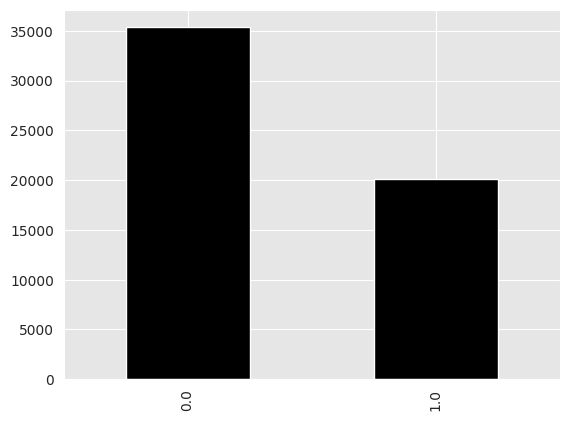

In [13]:
df[model_target].value_counts().plot.bar(color="black")
plt.show()

We notice that we are dealing with an imbalanced dataset. This means there are more examples for one type of results (here: 0; meaning individuals earning $\leq$ 50k). This is relevant for model choice and potential up-sampling or down-sampling to balance out the classes.

#### Feature distribution(s)

Let's now plot bar charts for the shortlist features of our dataset (as per above: shortlist - feature columns with less than 10 unique instance classes).

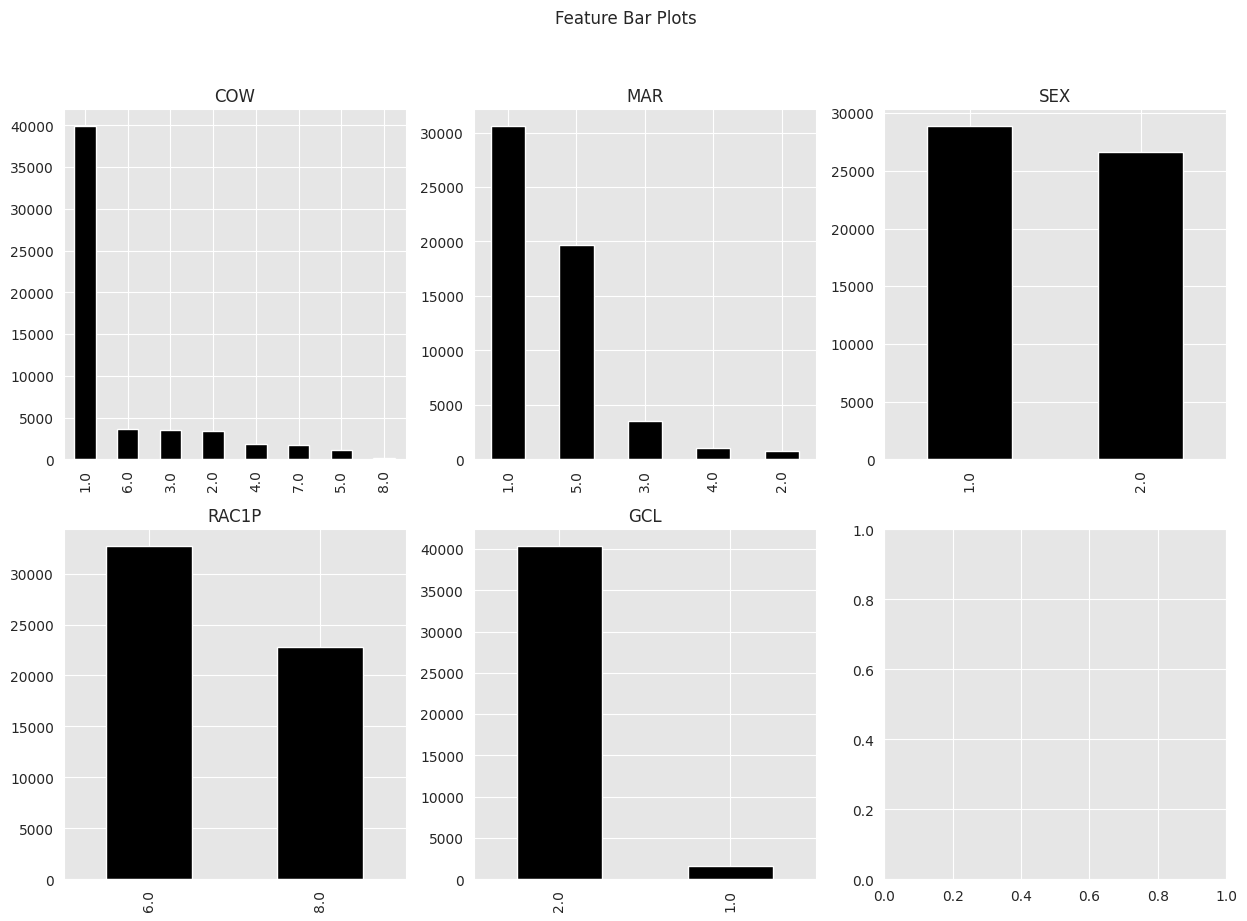

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Feature Bar Plots")

fts = range(len(shortlist_fts.index.tolist()))
for i, ax in zip(fts, axs.ravel()):
    df[shortlist_fts.index.tolist()[i]].value_counts().plot.bar(color="black", ax=ax)
    ax.set_title(shortlist_fts.index.tolist()[i])
plt.show()

### 2.2 <a name="22">Select features to build the model</a>
(<a href="#2">Go to Data Processing</a>)

During the extended EDA in the DATAPREP notebook, we learnt that `GCL` is a feature that is equally present in both outcome instances and also contains a lot of missing values. Therefore, we can drop it from the list of features we want to use for model build.

In [15]:
to_remove = "GCL"

# Drop 'GCL' feature from the respective list(s) - if applicable
if to_remove in model_features:
    model_features.remove(to_remove)
if to_remove in categorical_features:
    categorical_features.remove(to_remove)
if to_remove in numerical_features:
    numerical_features.remove(to_remove)

# Let's also clean up the dataframe and only keep the features and columns we need
df = df[model_features + [model_target]].copy(deep=True)

### 2.4 <a name="23">Train - Validation - Test Datasets</a>
(<a href="#2">Go to Data Processing</a>)

To get a training, test and validation set, we will use sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [16]:
train_data, test_data = train_test_split(
    df, test_size=0.1, shuffle=True, random_state=23
)

train_data, val_data = train_test_split(
    train_data, test_size=0.15, shuffle=True, random_state=23
)

# Print the shapes of the Train - Test Datasets
print(
    "Train - Test - Validation datasets shapes: ",
    train_data.shape,
    test_data.shape,
    val_data.shape,
)

Train - Test - Validation datasets shapes:  (42458, 12) (5551, 12) (7493, 12)


### 2.4 <a name="24">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#2">Go to Data Processing</a>)

Let's build a full model pipeline. We need pre-processing split per data type, and then combine everything back into a composite pipeline along with a model. To achieve this, we will use sklearns `Pipeline` and `ColumnTransformer`.

__Step 1 (set up pre-processing per data type):__
> For the numerical features pipeline, the __numerical_processor__ below, we impute missing values with the mean using sklearn's `SimpleImputer`, followed by a `MinMaxScaler` (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.

 > In the categorical features pipeline, the __categorical_processor__ below, we impute with a placeholder value and encode with sklearn's `OneHotEncoder`. If computing memory is an issue, it is a good idea to check categoricals' unique values, to get an estimate of many dummy features will be created by one-hot encoding. Note the __handle_unknown__ parameter that tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation/and or test set that was not present in the initial training set.
 
__Step 2 (combining pre-processing methods into a transformer):__ 
 > The selective preparations of the dataset features are then put together into a collective `ColumnTransformer`, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.
   
__Step 3 (combining transformer with a model):__ 
> Combine `ColumnTransformer` from Step 2 with a selected algorithm in a new pipeline. For example, the algorithm could be a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for classification problems.

In [17]:
### STEP 1 ###
##############

# Preprocess the numerical features
numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)
# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

### STEP 2 ###
##############

# Combine all data preprocessors from above
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
    ]
)


### STEP 3 ###
##############

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set/reach the parameters using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline(
    [
        ("data_processing", data_processor),
        ("lg", LogisticRegression(random_state=0)),
    ]
)

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config

set_config(display="diagram")
pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['AGEP', 'WKHP', 'PWGTP']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['COW', 'SCHL', 'MAR', 'OCCP',
                                                   'POBP', 'RELP', 'SEX',
                                                   'RAC1P'])])),
                ('lg', LogisticRegression(random_state=0))])

## 3. <a name="3">Train a Classifier</a>
(<a href="#0">Go to top</a>)

We use the pipeline with the desired data transformers, along with a Logistic Regression estimator for training.

### Model Training

We train the classifier with __.fit()__ on our training dataset. 

In [18]:
# Get train data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the train data
# Train data going through the Pipeline it's imputed (with means from the train data),
#   scaled (with the min/max from the train data),
#   and finally used to fit the model
pipeline.fit(X_train, y_train);

y_train_pred = pipeline.predict(X_train);

Next, we want to enforce Equalized Odds. To do so, we are going to use fairlearns `ThresholdOptimzer` to implement Equality of Opportunity. It is a postprocessing algorithm based on the paper [Equality of Opportunity in Supervised Learning](https://proceedings.neurips.cc/paper/2016/file/9d2682367c3935defcb1f9e247a97c0d-Paper.pdf). This technique takes  an existing classifier and the sensitive feature as inputs, and derives a transformation of the classifier's prediction to enforce the specified parity constraints.

In [19]:
# Set up ThresholdOptimizer
eo_model = ThresholdOptimizer(
    estimator=pipeline[-1],
    constraints="equalized_odds",
    objective="accuracy_score",
    grid_size=1000,
    flip=False,
    prefit=False,
    predict_method="deprecated",
)

# Adjust the results that the classifier would produce by letting ThresholdOptimizer know what the sensitive features are
eo_model.fit(X_train, y_train, sensitive_features=train_data["RAC1P"].values)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LogisticRegression(random_state=0))

In [20]:
# You can now use the fitted equalized odds post-processor and use it to create adjusted outcomes (predictions)
y_train_adjusted = eo_model.predict(
    X_train, sensitive_features=train_data["RAC1P"].values
)

In [21]:
# Join the data, adjusted predictions, original predictions, and the true outcome
eop_df_train = pd.DataFrame(
    {
        "RAC1P": train_data["RAC1P"].reset_index(drop=True),
        "y_train_adjusted": y_train_adjusted,
        "y_train_pred": y_train_pred,
        "y_train_true": train_data[model_target].reset_index(drop=True),
    }
)

## 4. <a name="4">Test the Classifier</a>
(<a href="#0">Go to top</a>)

Let's now evaluate the performance of the trained classifier on the test dataset. We use __.predict()__ this time. 


In [22]:
# Create the adjusted predictions for test and convert to dataframe
y_test_adjusted = eo_model.predict(
    test_data[model_features], sensitive_features=test_data["RAC1P"].values
)

# Let's have a look at the adjusted outputs for the test dataset
print(y_test_adjusted)

[0 1 1 ... 0 0 1]


(0.0, 2600.0)

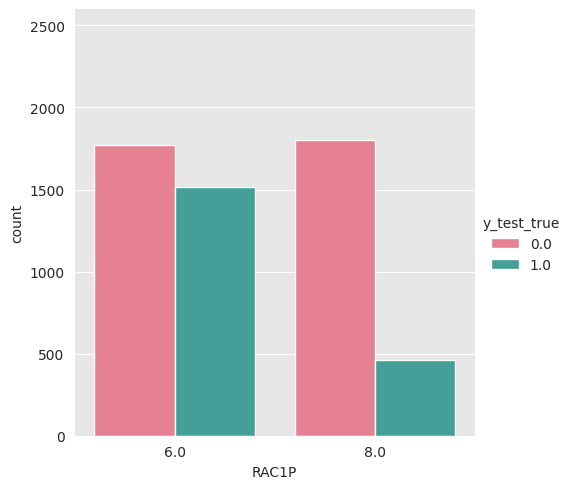

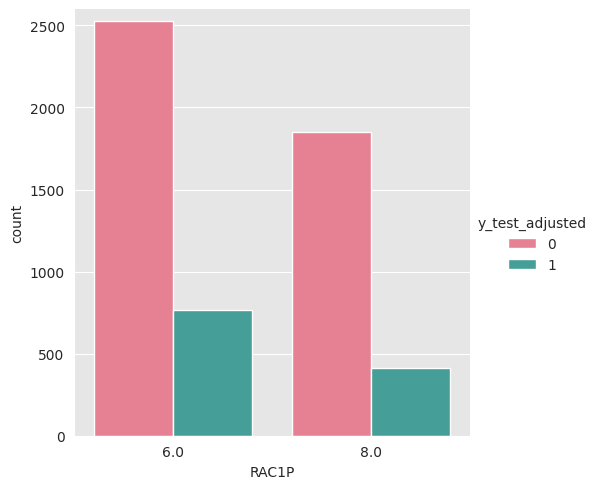

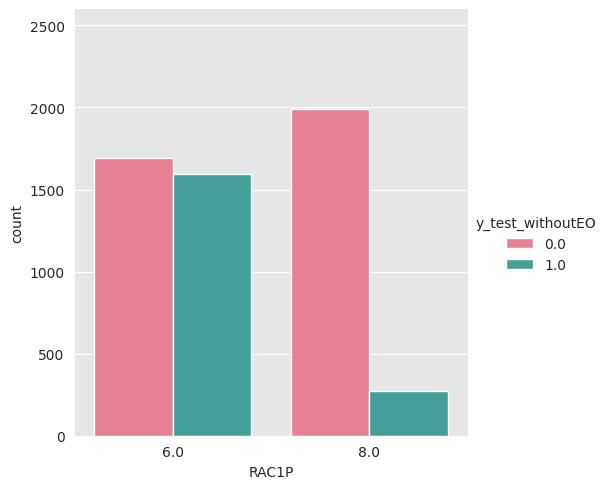

In [23]:
# Join the data, adjusted predictions, original predictions, and the true outcome
eop_df_test = pd.DataFrame(
    {
        "RAC1P": test_data["RAC1P"].reset_index(drop=True),
        "y_test_adjusted": y_test_adjusted,
        "y_test_true": test_data[model_target].reset_index(drop=True),
        "y_test_withoutEO": pipeline.predict(test_data[model_features]),
    }
)

sns.catplot(
    x="RAC1P",
    kind="count",
    hue="y_test_true",
    data=eop_df_test,
    palette="husl",
    ax=axs[0],
    sharey=True,
)
plt.ylim(0, 2600)

sns.catplot(
    x="RAC1P",
    kind="count",
    hue="y_test_adjusted",
    data=eop_df_test,
    palette="husl",
    ax=axs[1],
    sharey=True,
)
plt.ylim(0, 2600)

sns.catplot(
    x="RAC1P",
    kind="count",
    hue="y_test_withoutEO",
    data=eop_df_test,
    palette="husl",
    ax=axs[1],
    sharey=True,
)
plt.ylim(0, 2600)

You can clearly see that the ratios between the groups were adjusted drastically. The question remains whether it was fair the reduce the number of positive outcomes for RAC1P group 6. The odds are equal now, but this came at the cost of placing a lot of outcomes that were actually positive into the negative bucket. You can see that if you hadn't enforced Equalized Odds, the model would have actually amplified the existing bias in the dataset.

This is the end of the notebook.